In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from re import sub
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, scale
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, recall_score, precision_score
from sklearn.decomposition import PCA

from sklearn.inspection import permutation_importance

import warnings
warnings.simplefilter("ignore")
palette = sns.color_palette('coolwarm')


In [2]:
df = pd.read_csv("./datasets/hcvdat0.csv")

In [3]:
#drop indesx column
df = df.drop(df.iloc[:, [0]], axis=1)

In [4]:
# Mapping numeric values
df['Category'] = df['Category'].map({'0=Blood Donor': 0, '0s=suspect Blood Donor':0, "1=Hepatitis" : 1, "2=Fibrosis" : 1, "3=Cirrhosis" : 1})
df['Sex'] = df['Sex'].map({'m': 1, 'f': 2})

new_cols = {'ALB':'Albumin Blood Test (ALB) g/L ',
            'ALP':  'Alkaline Phosphatase Test (ALP) IU/L',
            'ALT': 'Alanine Transaminase Test (ALT) U/L',
            'AST' : 'Aspartate Transaminase Test (AST) U/L',
            'BIL': 'Bilirubin Blood Test (BIL) µmol/L',
            'CHE' : 'Cholinesterase (CHE) kU/L' ,
            'CHOL' : 'Cholesterol (CHOL) mmol/L',
            'CREA' : 'Creatinine Blod Test (CREA) µmol/L',
            'GGT' : 'Gamma-Glutamyl Transpeptidase Test (GGT) U/L',
            'PROT' : 'Protein Blood Test (PROT) g/L'}

In [5]:
# Custom function to replicate mode() - finds the most frequent value
def custom_mode(series):
    """
    Replicates pandas mode() function
    Returns the most frequent value(s) in a series
    """
    # Drop NaN values
    series_clean = series.dropna()
    
    # Count frequency of each value
    value_counts = series_clean.value_counts()
    
    # Get the maximum count (frequency)
    max_count = value_counts.max()
    
    # Get all values that have the maximum count (in case of ties)
    modes = value_counts[value_counts == max_count].index.tolist()
    
    # Return the first mode (like .mode()[0])
    return modes[0] if len(modes) > 0 else None

# Test the custom mode function
print("Testing custom_mode function:")
print(f"CHOL mode (pandas): {df['CHOL'].mode()[0]}")
print(f"CHOL mode (custom): {custom_mode(df['CHOL'])}")
print(f"\nALB mode (pandas): {df['ALB'].mode()[0]}")
print(f"ALB mode (custom): {custom_mode(df['ALB'])}")

Testing custom_mode function:
CHOL mode (pandas): 5.07
CHOL mode (custom): 5.07

ALB mode (pandas): 39.0
ALB mode (custom): 39.0


In [6]:
#rows that have missign values
print("Sum of missing values before: ", df.isnull().sum())
print("DataFrame shape before: ", df.shape)

#replace nan values with the most common values for each specific biometric feature
df['ALB'].replace(np.nan,df['ALB'].mode()[0],inplace=True)
df['ALP'].replace(np.nan,df['ALP'].mode()[0],inplace=True)
df['CHOL'].replace(np.nan,df['CHOL'].mode()[0],inplace=True)
df['PROT'].replace(np.nan,df['PROT'].mode()[0],inplace=True)
df['ALT'].replace(np.nan,df['ALT'].mode()[0],inplace=True)
print("Sum of missing values after: ",df.isnull().sum())
print("DataFrame shape after: ", df.shape)
print()


Sum of missing values before:  Category     0
Age          0
Sex          0
ALB          1
ALP         18
ALT          1
AST          0
BIL          0
CHE          0
CHOL        10
CREA         0
GGT          0
PROT         1
dtype: int64
DataFrame shape before:  (615, 13)
Sum of missing values after:  Category    0
Age         0
Sex         0
ALB         0
ALP         0
ALT         0
AST         0
BIL         0
CHE         0
CHOL        0
CREA        0
GGT         0
PROT        0
dtype: int64
DataFrame shape after:  (615, 13)



In [7]:
duplicate = df[df.duplicated()]
duplicate

,Category,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT


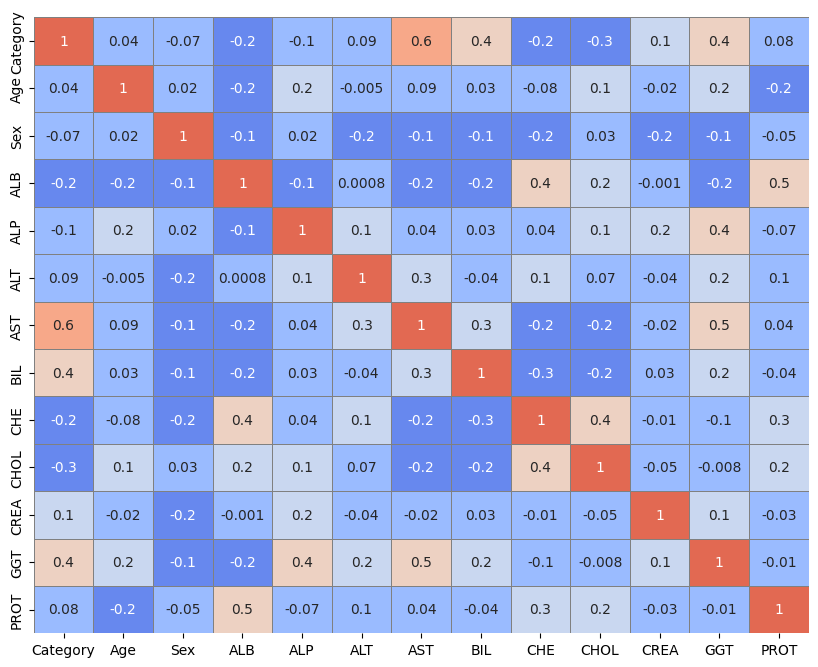

In [8]:
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, fmt='.1g', cmap=palette, cbar=False, linewidths=0.5, linecolor='grey');

Total Healthy Patients : 540 
Total Suspected Patients : 75 


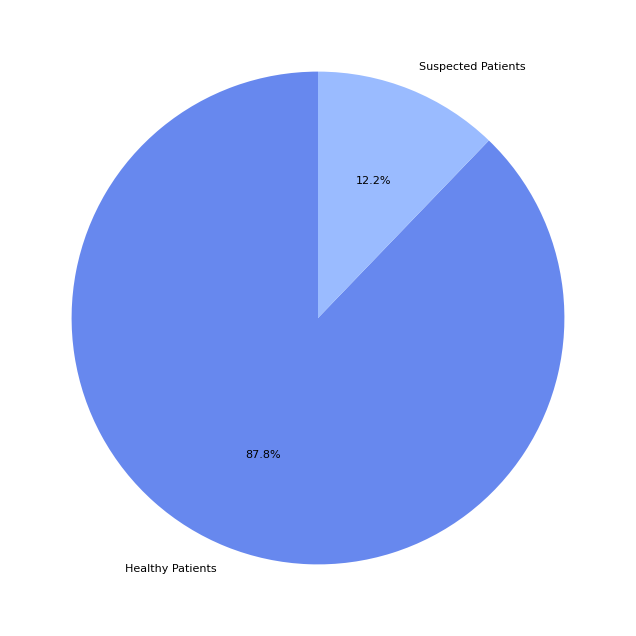

In [9]:
print ('Total Healthy Patients : {} '.format(df.Category.value_counts()[0]))

print ('Total Suspected Patients : {} '.format(df.Category.value_counts()[1]))
fig, ax = plt.subplots(figsize=(8,8))

plt.pie(x=df["Category"].value_counts(), colors=palette, labels=["Healthy Patients", "Suspected Patients"], autopct='%1.1f%%', startangle=90, textprops={'fontsize': 8})
# plt.pie(x=df["Category"].value_counts(), colors=palette, labels=["Blood Donor", "Suspect Blood Donor", "Hepatitis", "Fibrosis"], autopct='%1.1f%%', startangle=90, textprops={'fontsize': 8})

plt.show()

Sex
1    377
2    238
Name: count, dtype: int64


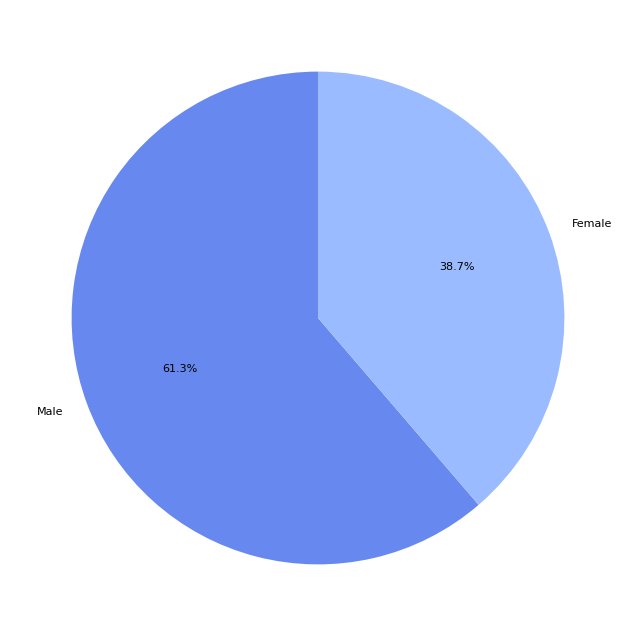

In [10]:
print(df["Sex"].value_counts())
fig, ax = plt.subplots(figsize=(8,8))
plt.pie(x=df["Sex"].value_counts(), colors=palette, labels=["Male","Female"], autopct='%1.1f%%', startangle=90, textprops={'fontsize': 8})
plt.show()

In [11]:
def plot_biometrics_histograms():
    fig, ax =plt.subplots(5,2, figsize=(20,25))     
    sns.histplot(x = df["Age"], hue = df["Category"], palette="viridis", kde=True, ax=ax[0,0]);
    ax[0,0].set_xlabel("Age",fontsize=15)

    sns.histplot(x = df["ALB"], hue = df["Category"], palette="viridis", kde=True, ax=ax[0,1]);
    ax[0,1].set_xlabel("ALB",fontsize=15)

    sns.histplot(x = df["ALP"], hue = df["Category"], palette="dark", kde=True, ax=ax[1,0]);
    ax[1,0].set_xlabel("ALP",fontsize=15)

    sns.histplot(x = df["ALT"], hue = df["Category"], palette="dark", kde=True, ax=ax[1,1]);
    ax[1,1].set_xlabel("ALT",fontsize=15)


    sns.histplot(x = df["AST"], hue = df["Category"], palette="flare", kde=True, ax=ax[2,0]);
    ax[2,0].set_xlabel("AST",fontsize=15)

    sns.histplot(x = df["BIL"], hue = df["Category"], palette="flare", kde=True, ax=ax[2,1]);
    ax[2,1].set_xlabel("BIL",fontsize=15)

    sns.histplot(x = df["CHE"], hue = df["Category"], palette="viridis", kde=True, ax=ax[3,0]);
    ax[3,0].set_xlabel("CHE",fontsize=15)

    sns.histplot(x = df["CHOL"], hue = df["Category"], palette="viridis", kde=True, ax=ax[3,1]);
    ax[3,1].set_xlabel("CHOL",fontsize=15);


    sns.histplot(x = df["CREA"], hue = df["Category"], palette="dark", kde=True, ax=ax[4,0]);
    ax[4,0].set_xlabel("CREA",fontsize=15)

    sns.histplot(x = df["GGT"], hue = df["Category"], palette="dark", kde=True, ax=ax[4,1]);
    ax[4,1].set_xlabel("GGT",fontsize=15);

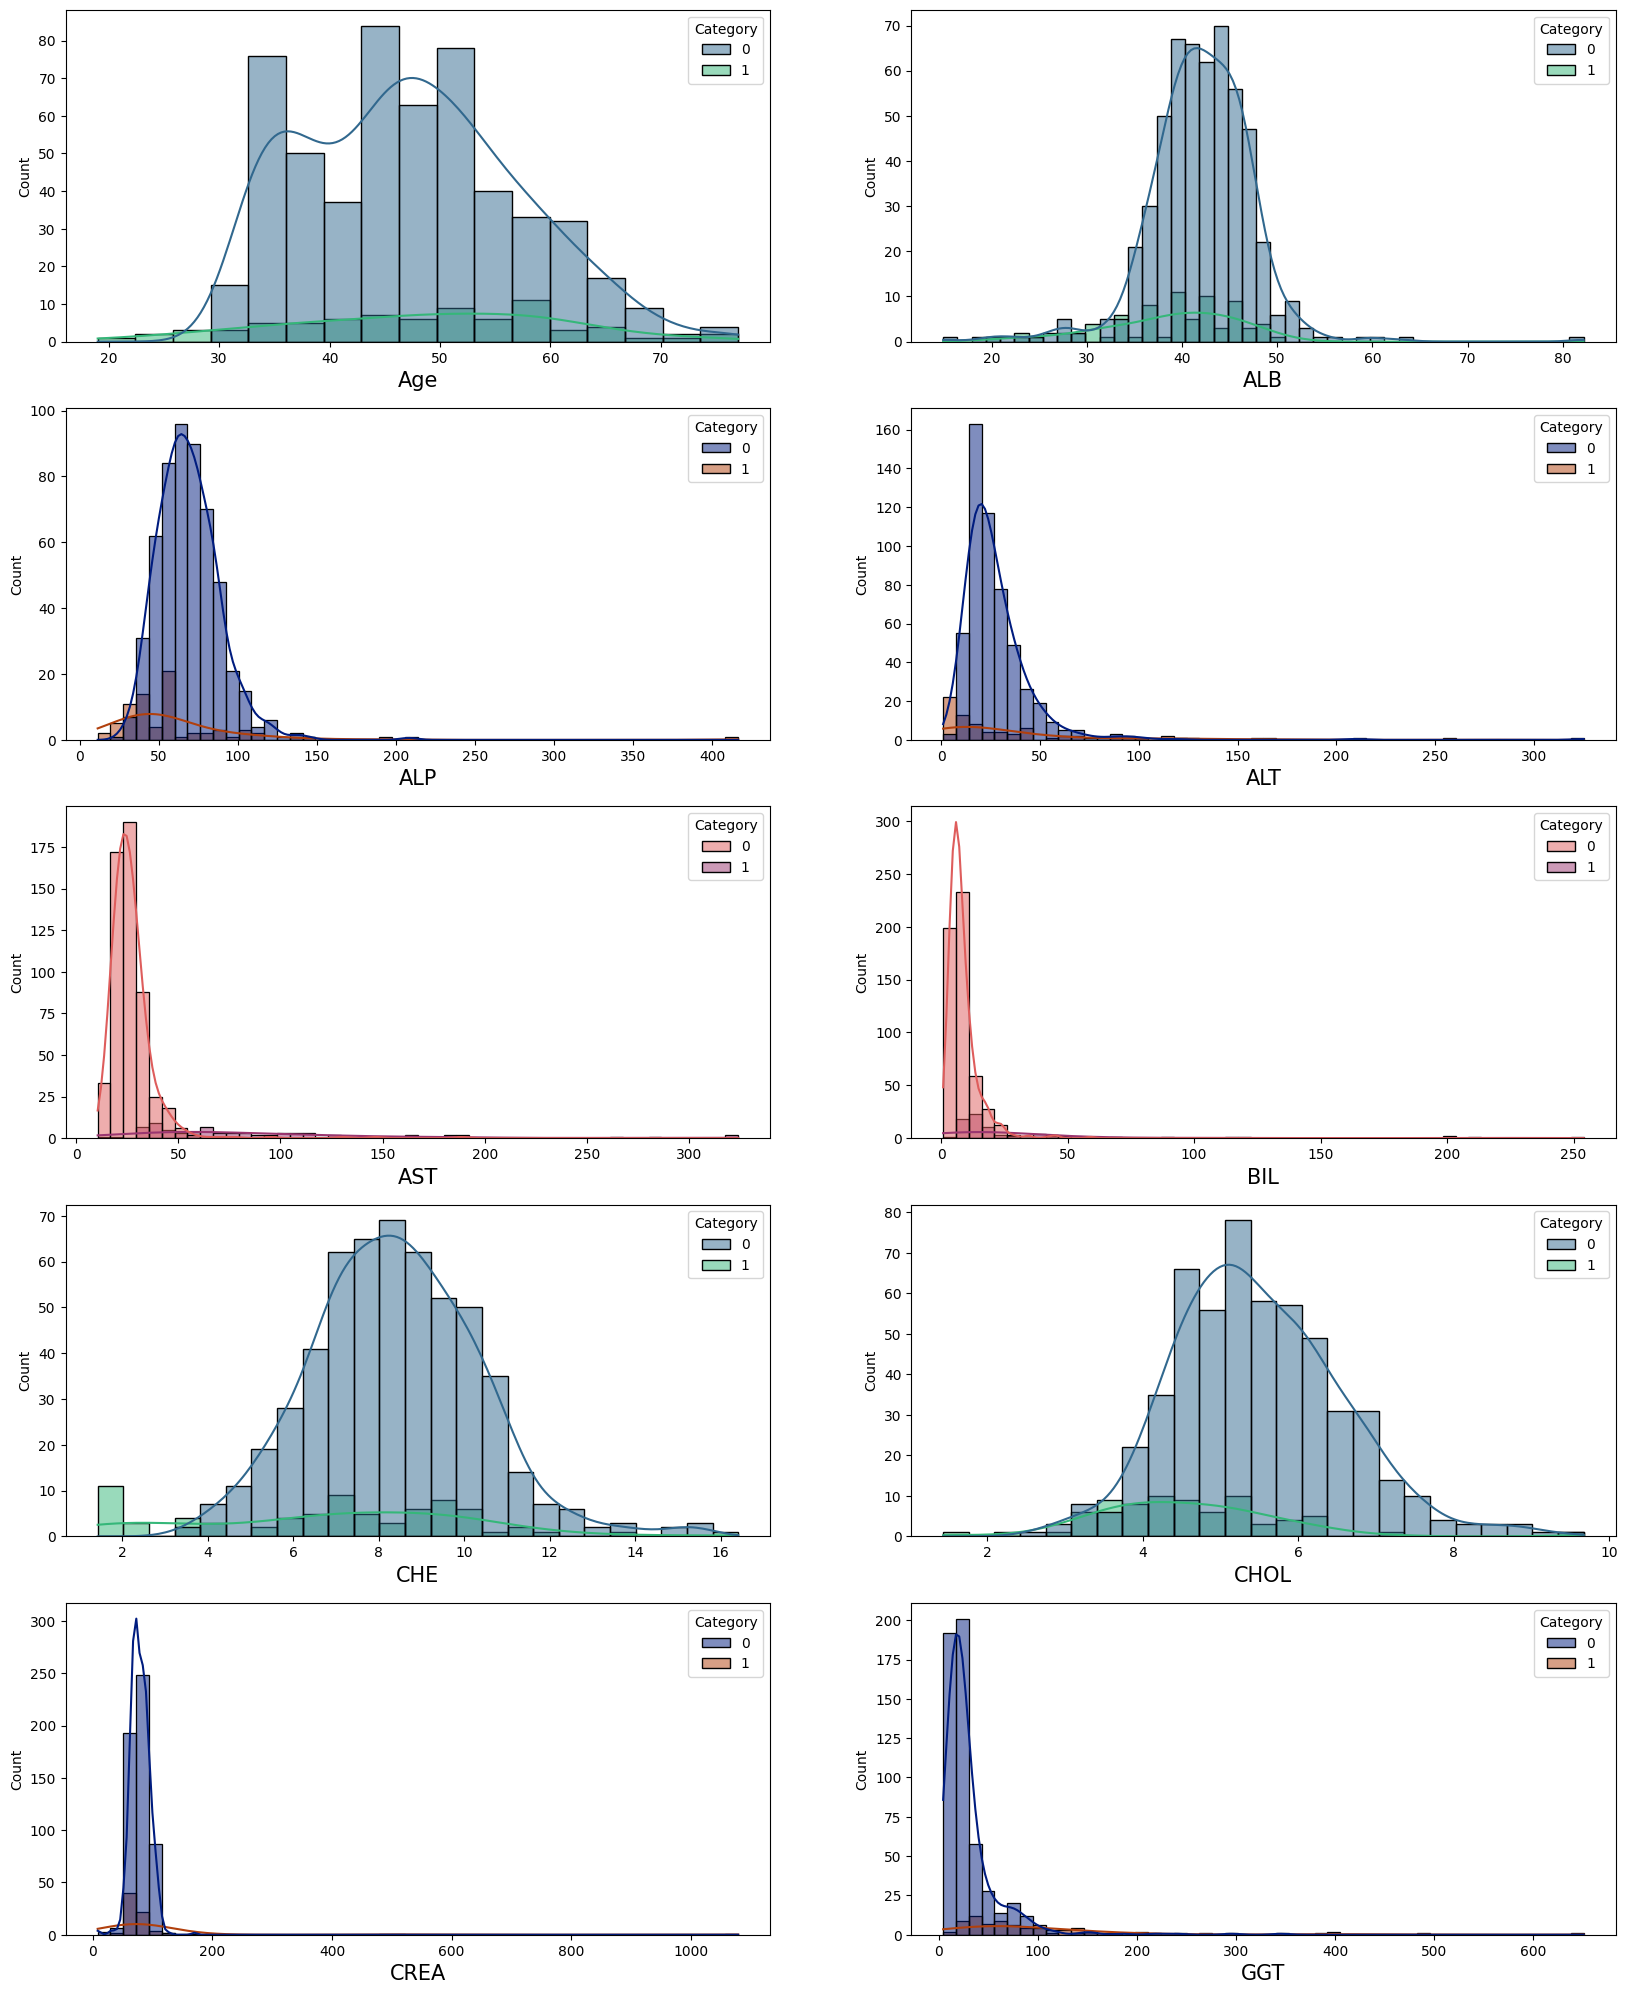

In [12]:
plot_biometrics_histograms()

In [13]:
#handling outliers
def calculate_outliers_percentage(df):

    # Calculate the interquartile range (IQR) for each column
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1

    # Calculate the lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Calculate the number of outliers in each column
    outliers = ((df < lower_bound) | (df > upper_bound))

    # Calculate the percentage of outliers in each column
    return outliers, outliers.sum()

In [14]:
outliers = pd.DataFrame(calculate_outliers_percentage(df)[1], columns=['Outliers (%)'])
outliers.index.name = 'Column Name'
outliers.reset_index(inplace=True)
outliers


,Column Name,Outliers (%)
0,Category,75
1,Age,1
2,Sex,0
3,ALB,27
4,ALP,13
5,ALT,36
6,AST,64
7,BIL,47
8,CHE,24
9,CHOL,12


In [15]:
# Create dataframe with mean and median for each feature and category
def mean_mode_distribution():
    numeric_features = list(df.columns.values)[1:]
    stats_data = []

    for feature in numeric_features:
        for category in df['Category'].unique():
            category_data = df[df['Category'] == category][feature]
            stats_data.append({
                'Feature': feature,
                'Category': category,
                'Mean': category_data.mode()[0],
                'Median': category_data.median()
            })

    return pd.DataFrame(stats_data)


In [16]:

# Outlier Detection and Class-wise Median Imputation
def compute_class_wise_median_for_outliers():
    numeric_features = list(df.columns.values)[1:]
    for feature in numeric_features:
        # Calculate IQR bounds (same logic as calculate_outliers_percentage)
        outliers, outliers_sum = calculate_outliers_percentage(df[feature])

        if outliers_sum: 
            # Replace outliers with class-wise median
            for category in df['Category'].unique():
                
                category_rows = df[df['Category'] == category]
                
                category_outlier_indices = [idx for idx in category_rows.index if outliers[idx]]
                if len(category_outlier_indices) > 0:
                    category_non_outlier_indices = [idx for idx in category_rows.index if not outliers[idx]]
                    if len(category_non_outlier_indices) > 0:
                        category_non_outliers = df.loc[category_non_outlier_indices, feature]
                        df.loc[category_outlier_indices, feature] = category_non_outliers.mode()[0]


In [17]:
compute_class_wise_median_for_outliers()

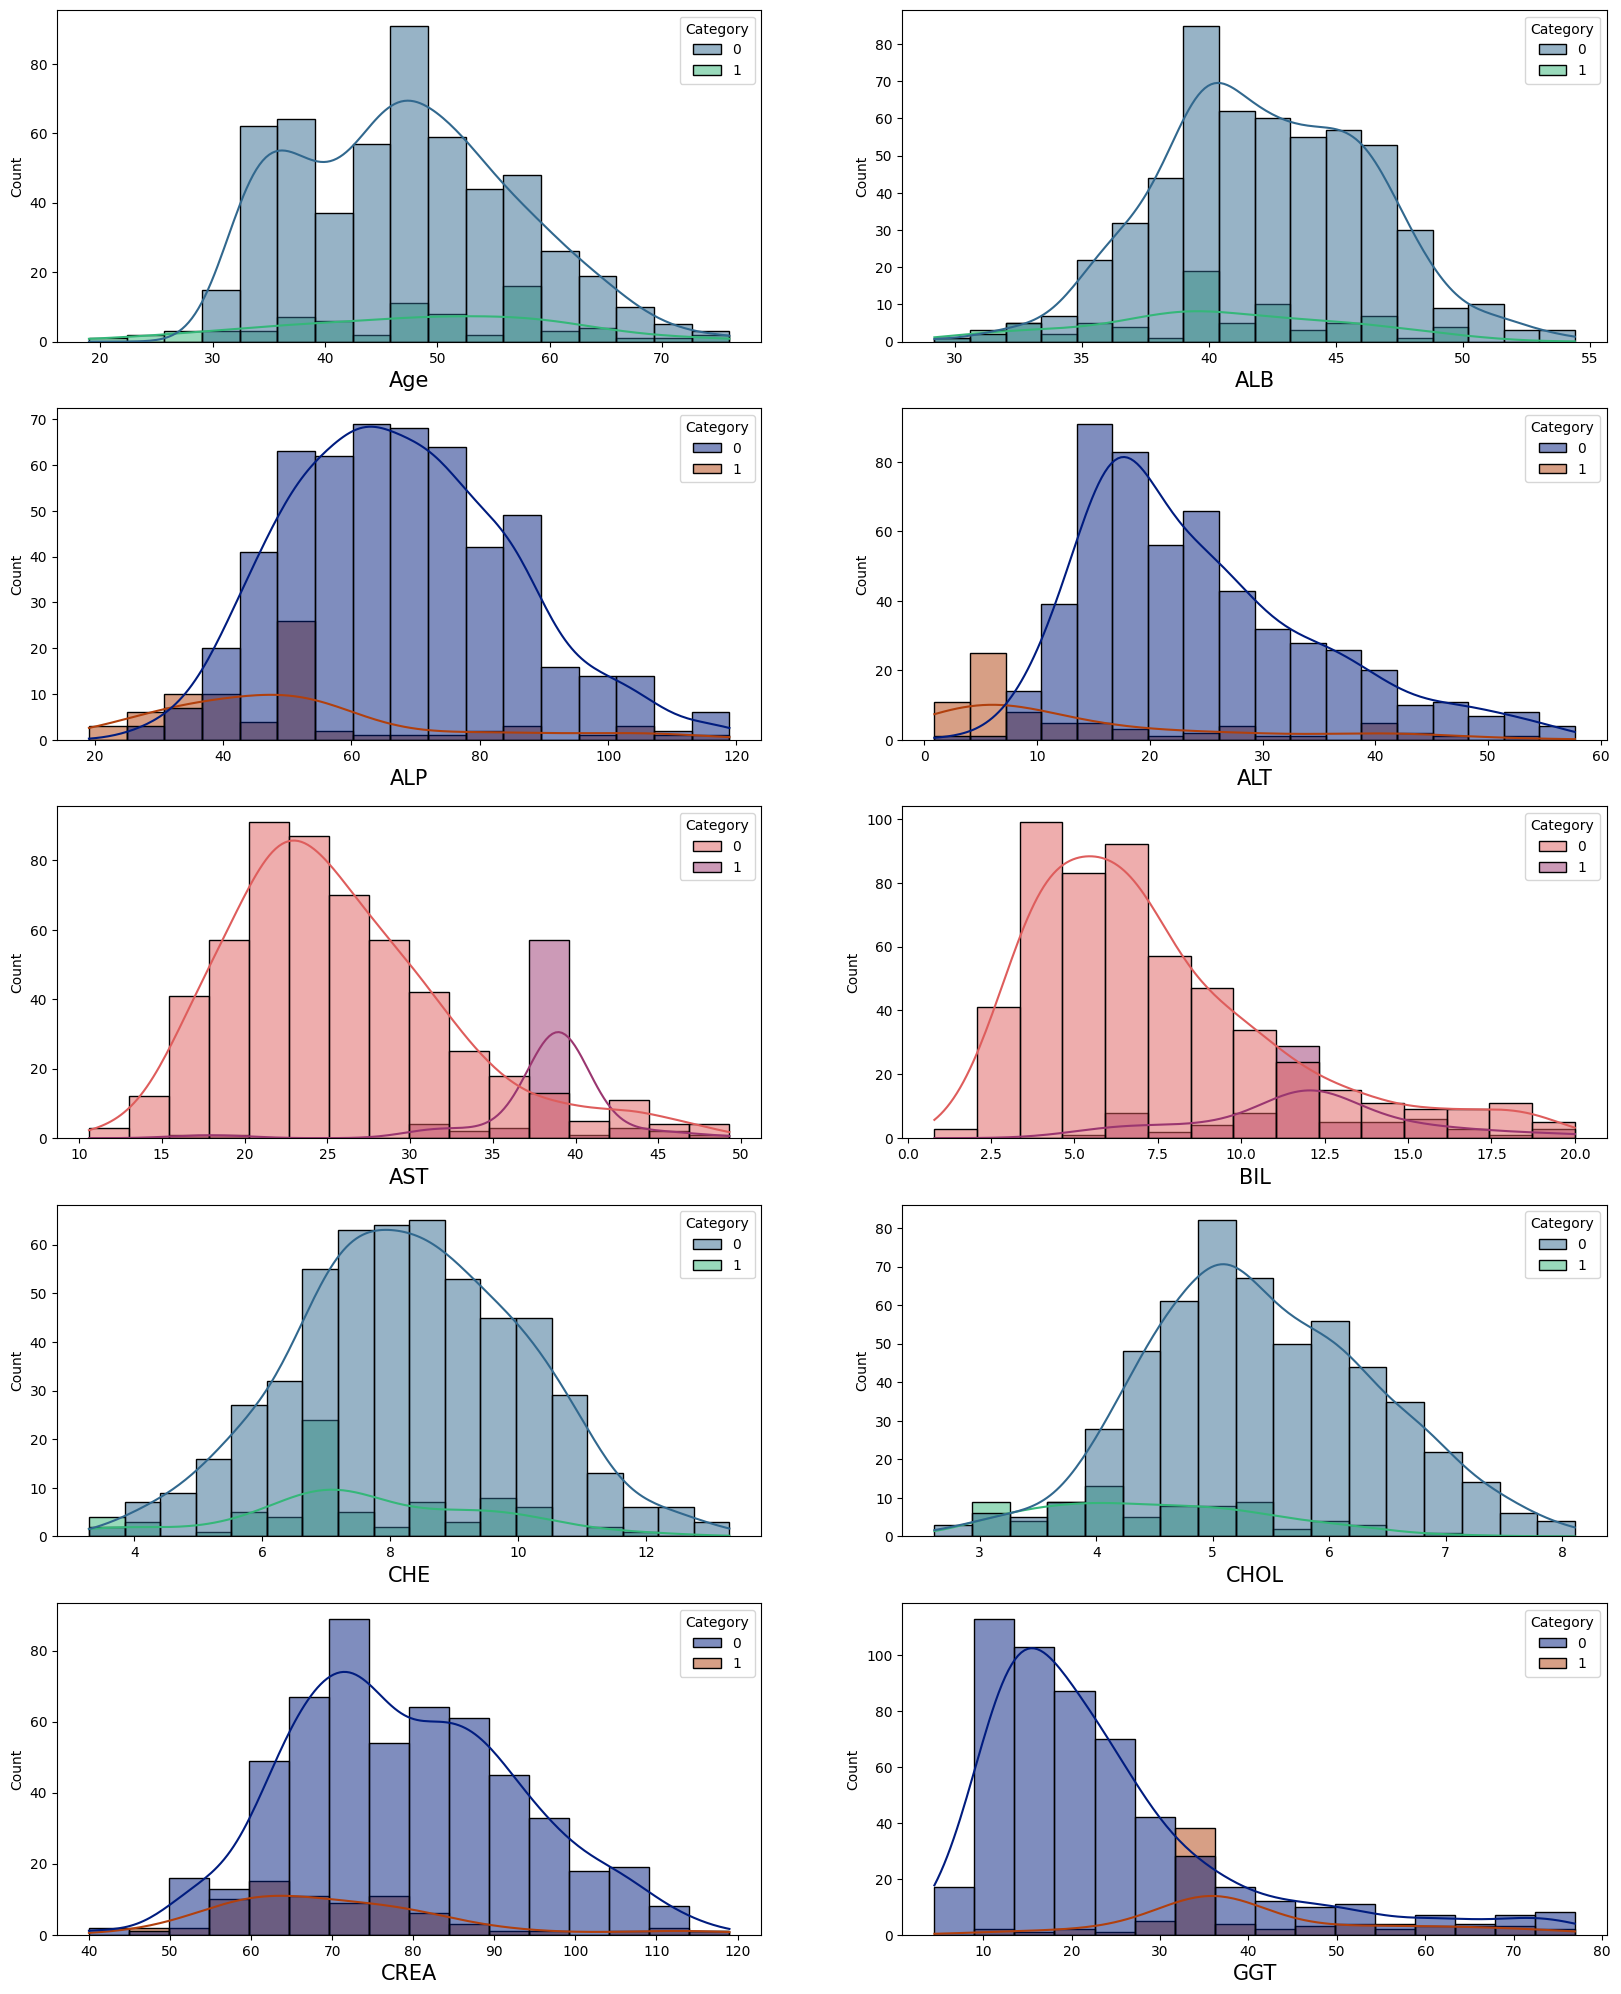

In [18]:
plot_biometrics_histograms()

In [19]:
distribution = mean_mode_distribution()
print(distribution)

   Feature  Category   Mean  Median
0      Age         0  46.00  47.000
1      Age         1  59.00  49.000
2      Sex         0   1.00   1.000
3      Sex         1   1.00   1.000
4      ALB         0  39.90  42.000
5      ALB         1  39.00  39.000
6      ALP         0  52.50  66.350
7      ALP         1  52.50  52.500
8      ALT         0  16.60  21.650
9      ALT         1   4.80   8.200
10     AST         0  22.00  24.600
11     AST         1  39.00  39.000
12     BIL         0   4.10   6.500
13     BIL         1  12.00  12.000
14     CHE         0   7.52   8.265
15     CHE         1   7.10   7.100
16    CHOL         0   5.07   5.310
17    CHOL         1   3.20   4.450
18    CREA         0  74.00  77.000
19    CREA         1  60.50  67.000
20     GGT         0  13.00  19.650
21     GGT         1  35.90  35.900
22    PROT         0  71.90  72.100
23    PROT         1  76.00  74.500


In [20]:
#split data in inputs and target 
X = df.drop('Category' , axis = 1).copy()
y = df['Category'].copy()

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)
# X_test_scaled = X_test
# X_train_scaled = X_train


In [22]:
# Initialize the model
clf_svm = SVC(random_state=42, kernel='rbf')
# Train the model on the full training set for final predictions
clf_svm.fit(X_train_scaled, y_train)


,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [23]:

#predict the model
y_pred = clf_svm.predict(X_test_scaled)

Accuracy:  0.926829268292683
Recall:  0.926829268292683
Precision:  0.9542682926829268
F1 Score:  0.9336813769475487


Text(0.5, 23.52222222222222, 'Predicted')

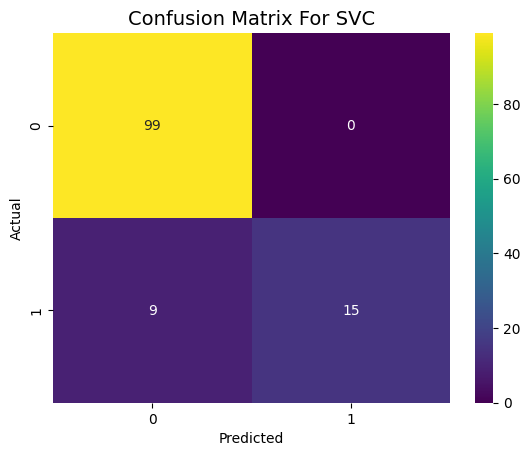

In [24]:
#display and visualize scores and the confusion matrix

print('Accuracy: ', accuracy_score(y_pred, y_test))
print('Recall: ', recall_score(y_pred, y_test, average="weighted"))
print('Precision: ', precision_score(y_pred, y_test, average="weighted"))
print('F1 Score: ', f1_score(y_pred, y_test, average="weighted"))

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="viridis")
plt.title("Confusion Matrix For SVC", fontsize=14)
plt.ylabel('Actual')
plt.xlabel('Predicted')

Text(0.5, 0, 'Permutation Importance')

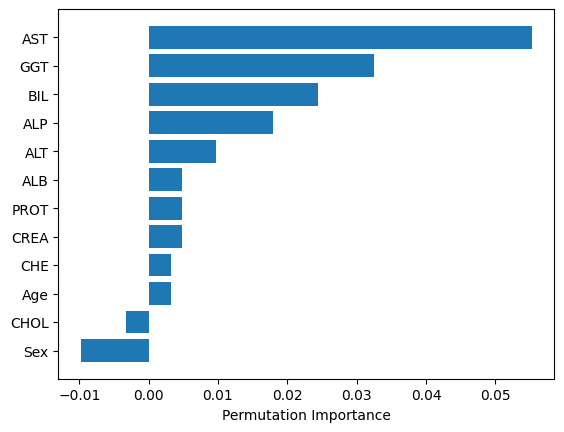

In [25]:
perm_importance = permutation_importance(clf_svm, X_test_scaled, y_test)

feature_names = list(X.columns.values)
features = np.array(feature_names)

sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx],)
plt.xlabel("Permutation Importance")


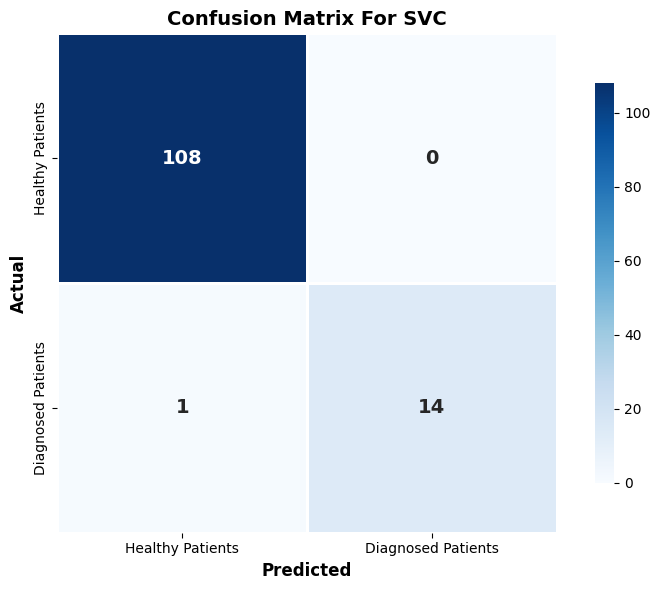


--- Fold 1 Results ---
Accuracy: 0.9919
Recall: 0.9919
Precision: 0.9919
F1 Score: 0.9917


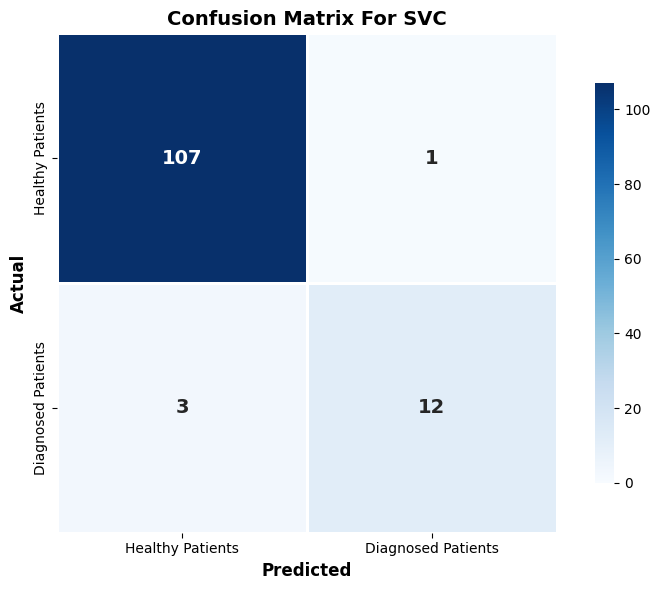


--- Fold 2 Results ---
Accuracy: 0.9675
Recall: 0.9675
Precision: 0.9667
F1 Score: 0.9665


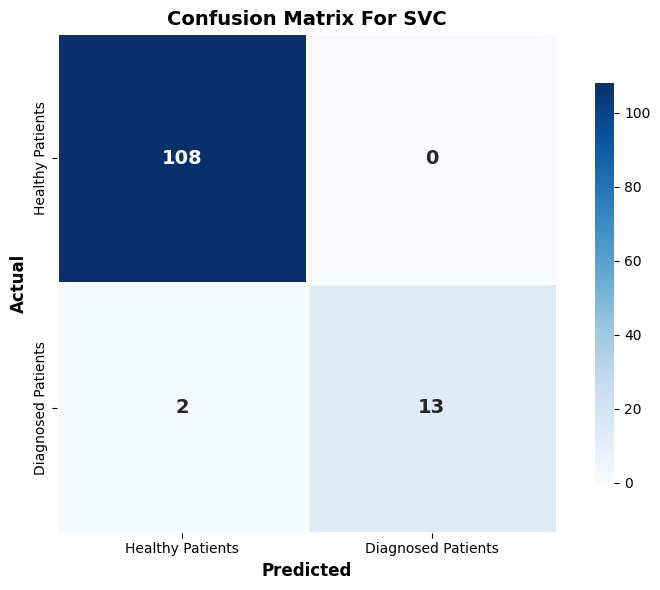


--- Fold 3 Results ---
Accuracy: 0.9837
Recall: 0.9837
Precision: 0.9840
F1 Score: 0.9832


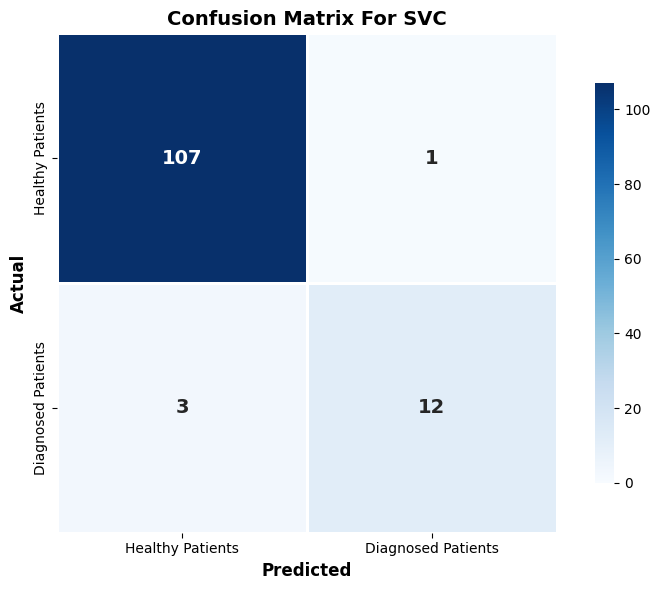


--- Fold 4 Results ---
Accuracy: 0.9675
Recall: 0.9675
Precision: 0.9667
F1 Score: 0.9665


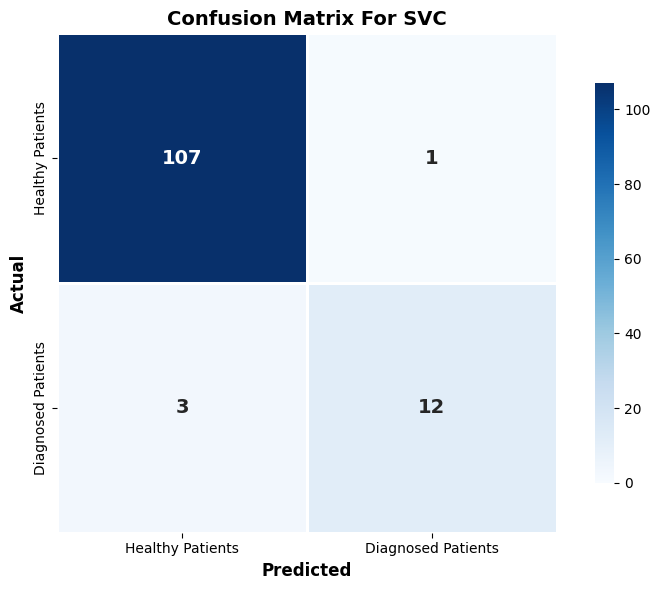


--- Fold 5 Results ---
Accuracy: 0.9675
Recall: 0.9675
Precision: 0.9667
F1 Score: 0.9665

COMPARISON OF ALL FOLDS:
 Fold  Accuracy  Recall  Precision  F1 Score
    1   0.99187 0.99187   0.991945  0.991748
    2   0.96748 0.96748   0.966672  0.966467
    3   0.98374 0.98374   0.984035  0.983234
    4   0.96748 0.96748   0.966672  0.966467
    5   0.96748 0.96748   0.966672  0.966467

SUMMARY STATISTICS:
       Accuracy    Recall  Precision  F1 Score
count  5.000000  5.000000   5.000000  5.000000
mean   0.975610  0.975610   0.975199  0.974877
std    0.011498  0.011498   0.012006  0.011902
min    0.967480  0.967480   0.966672  0.966467
25%    0.967480  0.967480   0.966672  0.966467
50%    0.967480  0.967480   0.966672  0.966467
75%    0.983740  0.983740   0.984035  0.983234
max    0.991870  0.991870   0.991945  0.991748

Best Fold (by Accuracy): Fold 1
Best Fold (by F1 Score): Fold 1


In [26]:
# Use Stratified K-Fold cross-validation for training and evaluation
X_fold = df.drop('Category' , axis = 1).copy()
y_fold = df['Category'].copy()

scaler_fold = StandardScaler()
X_fold_scaled = scaler.fit_transform(X_fold)


skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Store results for each fold
fold_results = []

# Iterate through each fold and make predictions
for fold_num, (train_idx, val_idx) in enumerate(skf.split(X_fold_scaled, y_fold), 1):
    # Split data for this fold
    X_fold_train = X_fold_scaled[train_idx]
    X_fold_val = X_fold_scaled[val_idx]
    y_fold_train = y_fold.iloc[train_idx] if hasattr(y_fold, 'iloc') else y_fold[train_idx]
    y_fold_val = y_fold.iloc[val_idx] if hasattr(y_fold, 'iloc') else y_fold[val_idx]
    
    # Train model on fold training data
    clf_svm.fit(X_fold_train, y_fold_train)
    
    # Make predictions on fold validation data
    y_fold_pred = clf_svm.predict(X_fold_val)
    
    # Calculate metrics for this fold
    fold_accuracy = accuracy_score(y_fold_val, y_fold_pred)
    fold_recall = recall_score(y_fold_val, y_fold_pred,  average="weighted")
    fold_precision = precision_score(y_fold_val, y_fold_pred,  average="weighted")
    fold_f1 = f1_score(y_fold_val, y_fold_pred,  average="weighted")
    
    # Create and display confusion matrix for this fold
    # Convert numeric labels to string labels for visualization
    label_mapping = {0: 'Healthy Patients', 1: 'Diagnosed Patients'}
    y_fold_val_labels = [label_mapping[int(val)] for val in y_fold_val]
    y_fold_pred_labels = [label_mapping[int(pred)] for pred in y_fold_pred]
    
    conf_matrix = confusion_matrix(y_fold_val_labels, y_fold_pred_labels, labels=['Healthy Patients', 'Diagnosed Patients'])
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", 
                vmin=0, vmax=None, square=True, linewidths=2, 
                xticklabels=['Healthy Patients', 'Diagnosed Patients'],
                yticklabels=['Healthy Patients', 'Diagnosed Patients'],
                cbar_kws={"shrink": 0.8}, annot_kws={"size": 14, "weight": "bold"})
    plt.title("Confusion Matrix For SVC", fontsize=14, fontweight='bold')
    plt.ylabel('Actual', fontsize=12, fontweight='bold')
    plt.xlabel('Predicted', fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Store results
    fold_results.append({
        'Fold': fold_num,
        'Accuracy': fold_accuracy,
        'Recall': fold_recall,
        'Precision': fold_precision,
        'F1 Score': fold_f1
    })
    
    print(f'\n--- Fold {fold_num} Results ---')
    print(f'Accuracy: {fold_accuracy:.4f}')
    print(f'Recall: {fold_recall:.4f}')
    print(f'Precision: {fold_precision:.4f}')
    print(f'F1 Score: {fold_f1:.4f}')

# Create DataFrame to compare all folds
fold_comparison = pd.DataFrame(fold_results)
print('\n' + '='*50)
print('COMPARISON OF ALL FOLDS:')
print('='*50)
print(fold_comparison.to_string(index=False))
print('\n' + '='*50)
print('SUMMARY STATISTICS:')
print('='*50)
print(fold_comparison[['Accuracy', 'Recall', 'Precision', 'F1 Score']].describe())
print('\n' + '='*50)
print(f'Best Fold (by Accuracy): Fold {fold_comparison.loc[fold_comparison["Accuracy"].idxmax(), "Fold"]}')
print(f'Best Fold (by F1 Score): Fold {fold_comparison.loc[fold_comparison["F1 Score"].idxmax(), "Fold"]}')
print('='*50)


In [27]:
# pca = PCA()
# X_train_pca = pca.fit_transform(X_train_scaled)
# per_var = np.round(pca.explained_variance_ratio_ * 100, decimals = 1)
# labels = [str(x) for x in range(1, len(per_var)+1)]
# plt.bar(x=range(1, len(per_var)+1), height=per_var)
# plt.tick_params(
#     axis='x',
#     which='both',
#     bottom=False,
#     top=False,
#     labelbottom=False)
# plt.ylabel('Percentage of Explained Variance')    
# plt.xlabel('Principal components')
# plt.title('Screen plot')
# plt.show()


In [28]:
# train_pc1_coords = X_train_pca[:, 0]
# train_pc2_coords = X_train_pca[:, 1]

# # Create a new scaler specifically for PCA coordinates (fit on training data only)
# pca_train_scaled = scale(np.column_stack((train_pc1_coords, train_pc2_coords)))
# param_grid = [ 
#     {
#         'C': [1, 10, 100, 1000],
#         'gamma': ['scale', 1, 0.1, 0.01, 0.001, 0.0001],
#         'kernel': ['rbf'] a
#     }
# ]
# optimal_params = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy', verbose=0)
# optimal_params.fit(pca_train_scaled, y_train)
# print(optimal_params.best_params_)

In [29]:
# clf_svm = SVC(random_state=42, C=1000, gamma=0.001)
# clf_svm.fit(pca_train_scaled, y_train)



In [30]:
# # Transform test data with the same PCA and scaler used for training
# # Step 1: Transform test data using the fitted PCA (use .transform(), not .fit_transform())
# X_test_pca = pca.transform(X_test_scaled)

# # Step 2: Extract PC1 and PC2 from test data
# test_pc1_coords = X_test_pca[:, 0]
# test_pc2_coords = X_test_pca[:, 1]

# # Step 3: Scale test PC coordinates using the same scaler fitted on training data
# pca_test_scaled = scale(np.column_stack((test_pc1_coords, test_pc2_coords)))

# # Step 4: Make predictions on the PCA-transformed test data
# y_pred_pca = clf_svm.predict(pca_test_scaled)

# # Step 5: Evaluate the model
# print('Accuracy with PCA: ', accuracy_score(y_test, y_pred_pca))
# print('Recall with PCA: ', recall_score(y_test, y_pred_pca))
# print('Precision with PCA: ', precision_score(y_test, y_pred_pca))
# print('F1 Score with PCA: ', f1_score(y_test, y_pred_pca))

# # Step 6: Display confusion matrix
# conf_matrix_pca = confusion_matrix(y_test, y_pred_pca)
# sns.heatmap(conf_matrix_pca, annot=True, fmt='d', cmap="viridis")
# plt.title("Confusion Matrix For SVC with PCA", fontsize=14)
# plt.ylabel('Actual')
# plt.xlabel('Predicted')
# plt.show()
